In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools

plt.rcParams['font.size'] = 14
COLOR = itertools.cycle(['C%i' % i for i in range(10)])

A/D conversion
=============

In [11]:
##CD = waves.CDFormatSampler('CD')

##SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
##DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
##BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic PCM samplers
# Define sampling frequency (Hz) and resolution (bits) to your heart's content
ADC_list = []
for sampler, freq, bits in [
    ('PCM 1', 44100, 3),   # Same CD frequency, lower resolution
    #('PCM 2', 14000, 16),  # Same CD resolution, lower frequency
    #('CD', 44100, 16),  # Same CD resolution, lower frequency
    ('LOW', 14000, 4),  # Same CD resolution, lower frequency
]:
    ADC = waves.PCMSampler(sampler, freq, bits)
    ADC.color = next(COLOR)
    ADC_list.append(ADC)

In [12]:
dither_setup = {
    'nodither': {
        'state': False,
        'label': 'Without dither',
        'c': 'C1',
        'w': 3,
    },
    'dither': {
        'state': True,
        'label': 'With dither',
        'c': 'C0',
        'w': 1,
    },
}
#dither_setup.pop('dither')

In [13]:
experiments = [
    (waves.AnalogSineWave, '1 kHz', 1e3, 6),
    (waves.AnalogSineWave, '6 kHz', 6e3, 7),
    #(waves.AnalogSineWave, '14 kHz', 14e3, 20),
    #(waves.AnalogSineWave, '14.7 kHz', 14.7e3, 12.5),
    #(waves.AnalogSineWave, '18 kHz', 18e3, 20),
    #(waves.AnalogSineWave, '20 kHz', 20e3, 30),
    #(waves.AnalogSineWave, '21 kHz', 21e3, 30),
    #(waves.AnalogSineWave, '22 kHz', 22e3, 30),
    #(waves.AnalogSineWave, '22 kHz', 22e3, 300),
    #(waves.AnalogSineWave, '22.05 kHz', 22.05e3, 30),
    #(waves.AnalogSineWave, '30 kHz', 30e3, 30),
]
exp_results = []

Let us see how the noise behaves without and with dither added:

PCM 1's stream without dither (8 levels): [4 4 4 5 5 5 6 6 6 6 ... 1 1 1 1 1 2 2 2 3 3]
LOW's stream without dither (16 levels): [8 10 12 14 14 12 10 8 5 3 ... 14 12 10 7 5 3 1 1 3 5]
PCM 1's stream with dither (8 levels): [4 4 4 5 5 5 5 6 6 6 ... 0 0 1 2 1 2 2 2 3 3]
LOW's stream with dither (16 levels): [7 10 13 13 14 13 10 7 5 3 ... 14 13 10 7 5 2 2 2 2 5]
PCM 1's stream without dither (8 levels): [4 6 6 5 3 1 1 3 5 6 ... 1 1 3 6 6 5 3 1 1 2]
LOW's stream without dither (16 levels): [8 10 3 14 1 12 5 7 10 3 ... 7 10 3 14 1 12 5 7 10 3]
PCM 1's stream with dither (8 levels): [3 6 6 5 3 1 1 3 6 6 ... 1 1 3 5 6 5 3 1 0 2]
LOW's stream with dither (16 levels): [7 10 3 14 1 12 5 8 11 2 ... 8 11 2 13 1 12 5 7 10 2]


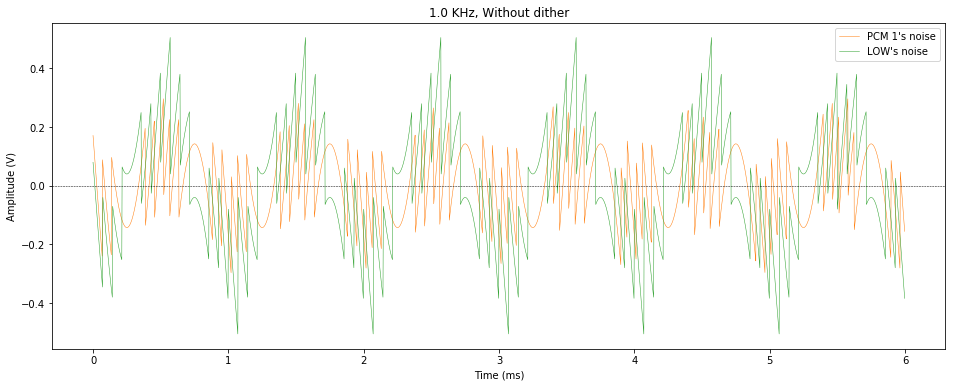

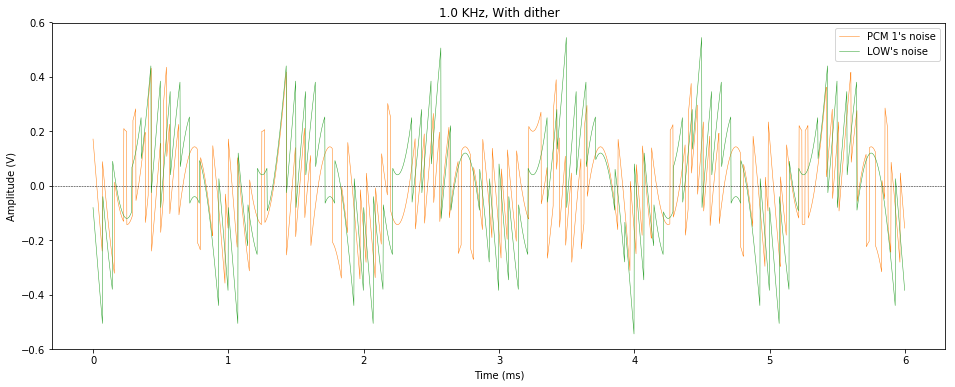

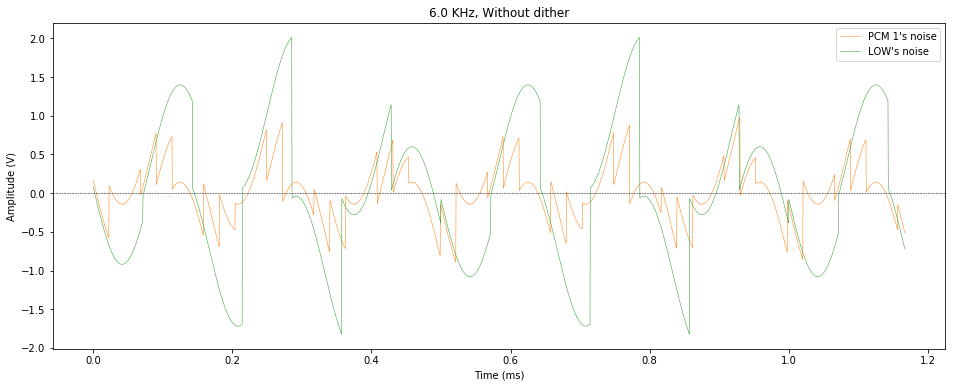

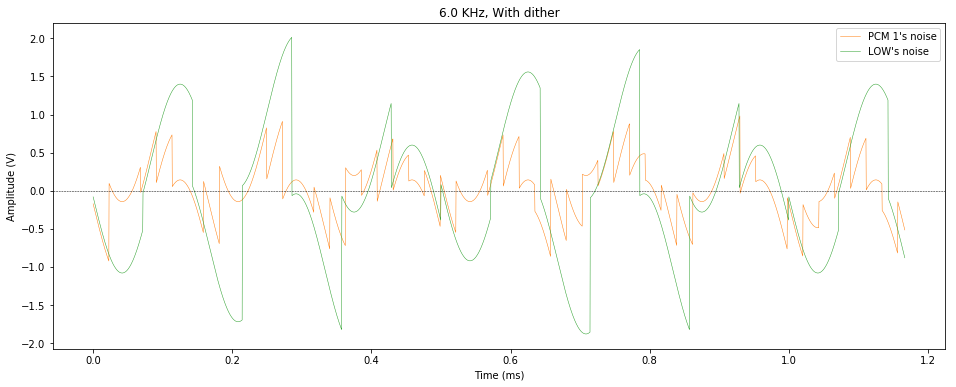

In [15]:
digi_signal = {}
noise_signal = dict([(k, {}) for k in dither_setup.keys()])
plots_shown = 'zn' # a for analog, d for digital, n for noise, g for grids, z for zero line

for wavetype, wlabel, f, n_waves in experiments:
    audio = wavetype(wlabel, f)
    freq = "%.1f KHz" % (f/1e3)
    length = n_waves * 1/f
    dith_results = []
    for dithering, setup in dither_setup.items():
        fig, ax = plt.subplots()
        digi_signal[dithering] = dict([(ADC.label, {}) for ADC in ADC_list])
        if 'a' in plots_shown:
            noise_signal[dithering]['time_domain'], _ = audio.view(
                ax, length, color='k', lw=1, alpha=0.5)
        ADC_results = []
        for ADC in ADC_list:
            # sample:
            converted, noise_signal[dithering][ADC.label] = ADC.quantize(
                audio, length, dither=setup['state'])
            if 'd' in plots_shown:
                converted.view(ax, lw=1.5, label=ADC.label, color=ADC.color)
            
            signal_domain = audio.time_array(length)
            if 'n' in plots_shown:
                ax.plot(signal_domain*1000, noise_signal[dithering][ADC.label], lw=0.5, ls='-', 
                        color=ADC.color, label=waves.of(ADC.label) + ' noise')
            
            ADC_results.append(converted)
            digi_signal[dithering][ADC.label]['time_domain'] = converted.t
            digi_signal[dithering][ADC.label]['signal'] = converted.y
            print(waves.of(ADC.label), 'stream', setup['label'].lower(), 
                  '(%i levels):' % ADC.levels, waves.shortlist(converted.stream, show=10)
                 )
        dith_results.append(ADC_results)

        if 'g' in plots_shown:
            # Show grid of ADC with the lowest sampling frequency:
            ADC = sorted(ADC_list, key=lambda ADC: ADC.sampling_frequency)[0]
            # but only if not many sampling intervals:
            if length/ADC.sampling_interval <= 100:
                [ax.axvline(t*1000, color=ADC.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, ADC.sampling_interval)]

            # Show grid of ADC with the lowest resolution:
            ADC = sorted(ADC_list, key=lambda ADC: ADC.amplitude_resolution)[0]
            # but only if not more than 4-bit, since too many levels
            if ADC.amplitude_resolution <= 4:
                [ax.axhline(A, color=ADC.color, lw=1, ls=':', alpha=0.5) for A in ADC.reconstruct(np.arange(ADC.levels))]

        ax.legend()
        if 'z' in plots_shown:
            ax.axhline(0, lw=0.5, ls='--', color='k')
        ax.set_title(', '.join([freq, setup['label']]
        ))
        ax.set_ylabel('Amplitude (V)')
        ax.set_xlabel('Time (ms)')
        fig.set_size_inches(16, 6)
        
        #w = np.linspace(ADC.amp_min, ADC.amp_max, 2000)
        #Q = ADC.reconstruct(ADC.classify(w))
        #plt.clf()
        #plt.grid()
        #plt.plot(w, Q)
    exp_results.append(dith_results)

In [6]:
results = [r[0][0] for r in exp_results]

D/A conversion
============

In [8]:
results[0].stream

array([4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4,
       4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4,
       4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 4,
       4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4,
       4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4,
       4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3,
       3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4,
       4, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3,
       3])

The noise is more decorrelated from the signal when dither is added. However, this comes at the cost of increased noise power:

In [ ]:
"""
def show_noise_signal_correlation(signal, dither_setup, noises, ADC):
    fig, ax = plt.subplots(1, 2)
    for dithering, setup in dither_setup.items():
        analog = signal.function(noises[dithering]['time_domain'])
        ax[0].scatter(analog, noises[dithering][ADC.label], color=setup['c'], label=setup['label'])
        ax[1].plot(*waves.twopar_correlation(analog, noises[dithering][ADC.label]), color=setup['c'], lw=setup['w'], label=setup['label'])
    ax[0].legend()
    ax[0].set_xlabel('Signal amplitude')
    ax[0].set_ylabel('Noise amplitude')
    ax[1].set_ylim(-1, 1)
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Signal-noise correlation')
    ax[1].legend()
    fig.suptitle(ADC.label)
    fig.set_size_inches(16, 6)

for ADC in ADC_list:
    show_noise_signal_correlation(audio, dither_setup, noise_signal, ADC)
"""

PCM 2 is unaffected, probably because of the high resolution, but for PCM 1 we can see that the correlation is reduced although the noise amplitude has enhanced.

In [ ]:
"""
for ADC in ADC_list:
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        ax.plot(noise_signal[dithering]['time_domain']*1000, 
                [st.moment(noise_signal[dithering][ADC.label][:t+1], moment=2) for t in range(len(noise_signal[dithering]['time_domain']))], 
                color=setup['c'], lw=setup['w'], label=setup['label'])
        ax.set_title(ADC.label)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Noise power')
        ax.legend()
        fig.set_size_inches(16, 6)
"""

Here we can also see, for PCM 1, that the introduction of dither enhanced the total noise power.
Let us also have a look at the Fourier transform of the signals.

In [ ]:
"""
from scipy.fftpack import fft, fftfreq, fftshift

def fourier(dither_setup, digi_signal, ADC):
    style = iter([('C1', 3), ('C0', 1)])
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        t = digi_signal[dithering][ADC.label]['time_domain']
        yf = fft(digi_signal[dithering][ADC.label]['signal'])
        tf = fftfreq(t.size, d=ADC.sampling_interval)
        tf, yf = fftshift(tf), fftshift(yf)
        c, w = next(style)
        ax.vlines(tf/1000, 0, np.abs(yf)*2/t.size, color=setup['c'], lw=setup['w'], label=setup['label'])
    ax.legend()
    #ax.set_xscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(ADC.label)
    ax.grid(which='both', alpha=0.5)
    fig.set_size_inches(16, 6)
"""

In [ ]:
"""
for ADC in ADC_list:
    fourier(dither_setup, digi_signal, ADC)
"""